# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
import scipy.signal as signal
import random
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

# Задание окружения

In [2]:
figures = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "figures")

# Работа с данными

## Видеоряд

In [3]:
video_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "Film stimulus.mp4")

In [4]:
def video_to_frames():
    videocap = cv2.VideoCapture(video_path)
    success, frame = videocap.read()
    count = 1
    while success:
        cv2.imwrite(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                                "src", "frames", f"frame_{count}.jpg"), frame)    
        success, frame = videocap.read()
        count += 1

In [5]:
#video_to_frames()

In [6]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2048)

c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        frame_tensor = preprocess(frame)
        frame_tensor = frame_tensor.unsqueeze(0)
        yield frame_tensor

In [9]:
def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        # передача картинки в модель и получение выходных данных
        with torch.no_grad():
            output = model(frame_tensor)
        # преобразование выходных данных в вектор
        vector = output.numpy().flatten()
        yield vector

In [10]:
#vector_list = [vector for vector in tensors_to_vectors()]
#np.save("vector_list", vector_list)
vector_list = np.load(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "vector_list.npy"))

## Снимки фМРТ

In [11]:
class Sub:

    subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',\
                  '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',\
                  '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

    def __init__(self, number):
        if not number in Sub.subs_with_fmri:
            raise ValueError(f"У {number} испытуемого отсутствуют снимки фМРТ")
        else:
            self.number = number
        self.path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "ds003688-download", f"sub-{self.number}",\
                                    "ses-mri3t", "func", f"sub-{self.number}_ses-mri3t_task-film_run-1_bold.nii.gz")
        self.scan = nib.load(self.path)
        self.data = self.scan.get_fdata()
        self.tensor = torch.tensor(self.data)
        self.tensor_np = self.tensor.numpy()

# Построение линейной модели

In [12]:
class Preprocessor:

    def __init__(self, sub, dt, coef, train_size=0.7):
        self.sub = sub
        self.dt = dt
        self.coef = coef
        self.train_size = train_size

        self.nu = 25 # частота видео
        self.mu = 641. / 390. # частота снимков фМРТ
        self.d1 = self.sub.tensor.shape[0] # размерности снимка фМРТ до сжатия
        self.d2 = self.sub.tensor.shape[1]
        self.d3 = self.sub.tensor.shape[2]
        self.d4 = self.sub.tensor.shape[3]
        self.d = 2048 # длина вектора признакового описания изображения
        self.N = 641 - int(self.mu * self.dt) # N - количество снимков fMRI

        self.train, self.test = self.get_train_test()

    @staticmethod
    def preprocess(v):
        return (v - v.min()) / (v.max() - v.min())

    @staticmethod
    def MSE(A):
        m, n = A.shape
        return 1 / (m * n) * np.linalg.norm(A, "fro") ** 2

    def get_train_test(self):
        pairs = [(int(i * self.nu / self.mu), int(self.mu * self.dt + i)) for i in range(self.N)] # (номер изображения, номер снимка)

        if (self.coef > 1): # сжатие снимка фМРТ
            maxpool = torch.nn.MaxPool3d(kernel_size=self.coef, stride=self.coef)
            input_tensor = self.sub.tensor.permute(3, 0, 1, 2)
            output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
            self.sub._tensor = output_tensor
        else:
            self.sub._tensor = self.sub.tensor
        
        self._d1 = self.sub._tensor.shape[0]
        self._d2 = self.sub._tensor.shape[1]
        self._d3 = self.sub._tensor.shape[2]
        self._d4 = self.sub._tensor.shape[3]
        
        scans_list = [self.sub._tensor[:, :, :, i] for i in range(self.d4)] # список тензоров снимков фМРТ
        voxels = [scan.reshape(self._d1 * self._d2 * self._d3).numpy() for scan in scans_list] # список снимков фМРТ, развернутых в векторы
        data = [(vector_list[n], voxels[k]) for n, k in pairs] # (изображение, снимок)

        # train, test
        l = int(self.train_size * self.d4) # размер обучающей выборки
        train, test = data[:l], data[l:]
            
        train = [(pair[0], self.preprocess(pair[1])) for pair in train]
        test = [(pair[0], self.preprocess(pair[1])) for pair in test]

        return train, test
    

## Предсказание снимка

In [13]:
class LinearPredictor(Preprocessor):
    
    def __init__(self, sub, dt, coef, alpha, train_size=0.7):
        super().__init__(sub, dt, coef, train_size)
        self.delta = False
        self.alpha = alpha
        self.X_train, self.Y_train, self.X_test, self.Y_test = self.get_XY()

    def get_XY(self):
        X_train = np.array([pair[0] for pair in self.train])
        Y_train = np.array([pair[1] for pair in self.train]).T
        X_test = np.array([pair[0] for pair in self.test])
        Y_test = np.array([pair[1] for pair in self.test]).T
        return X_train, Y_train, X_test, Y_test

    def predict(self):
        W = [] # матрица весов модели

        if (self.alpha > 0):
            A = np.linalg.inv(self.X_train.T @ self.X_train + self.alpha * np.identity(self.X_train.shape[1])) @ self.X_train.T
        else:
            A = np.linalg.pinv(self.X_train)
        
        for i in range(self._d1 * self._d2 * self._d3):
            Y_train_vector = self.Y_train[i]
            w = A @ Y_train_vector
            W.append(w)
            
        self.W = np.array(W) # w будут строками

        self.Y_train_predicted = W @ self.X_train.T
        self.Y_test_predicted = W @ self.X_test.T

        self.MSE_train = self.MSE(self.Y_train_predicted - self.Y_train)
        self.MSE_test = self.MSE(self.Y_test_predicted - self.Y_test)

## Предсказание разницы между снимками

In [14]:
class LinearDeltaPredictor(Preprocessor):
    def __init__(self, sub, dt, coef, alpha, train_size=0.7):
        super().__init__(sub, dt, coef, train_size)
        self.delta = True
        self.alpha = alpha
        self.X_train, self.Y_train, self.deltaY_train, self.X_test, self.Y_test, self.deltaY_test = self.get_XY()

    def get_XY(self):
        delta_train = [(self.train[n][0], self.train[n][1] - self.train[n-1][1]) for n in range(1, len(self.train))]
        delta_test = [(self.test[n][0], self.test[n][1] - self.test[n-1][1]) for n in range(1, len(self.test))]
        Y_train = np.array([pair[1] for pair in self.train]).T
        Y_test = np.array([pair[1] for pair in self.test]).T
        X_train = np.array([pair[0] for pair in delta_train])
        deltaY_train = np.array([pair[1] for pair in delta_train]).T
        X_test = np.array([pair[0] for pair in delta_test])
        deltaY_test = np.array([pair[1] for pair in delta_test]).T
        return X_train, Y_train, deltaY_train, X_test, Y_test, deltaY_test

    def predict(self):
        W = [] # матрица весов модели

        if (self.alpha > 0):
            A = np.linalg.inv(self.X_train.T @ self.X_train + self.alpha * np.identity(self.X_train.shape[1])) @ self.X_train.T
        else:
            A = np.linalg.pinv(self.X_train)
        
        for i in range(self._d1 * self._d2 * self._d3):
            deltaY_train_vector = self.deltaY_train[i]
            w = A @ deltaY_train_vector
            W.append(w)
            
        self.W = np.array(W) # w будут строками

        self.deltaY_train_predicted = W @ self.X_train.T
        self.deltaY_test_predicted = W @ self.X_test.T
        self.Y_train_predicted = np.delete(self.Y_train, -1, 1) + self.deltaY_train_predicted
        self.Y_test_predicted = np.delete(self.Y_test, -1, 1) + self.deltaY_test_predicted
    
        self.MSE_train = self.MSE(self.Y_train_predicted - np.delete(self.Y_train, 0, 1))
        self.MSE_test = self.MSE(self.Y_test_predicted - np.delete(self.Y_test, 0, 1))

# Построение срезов снимков

In [22]:
class Vizualizer:

    def __init__(self, predictor):
        self.predictor = predictor
        self.figures = "figures_delta" if self.predictor.delta else "figures"
        self.filename = f"sub-{self.predictor.sub.number}-{self.predictor.dt}-{self.predictor.coef}"
        if self.predictor.alpha > 0:
            self.filename += f"-{self.predictor.alpha}"

    def show_scan_slice(self, scan, scan_number: int, dim: int, slice: int, title, filename_end):
        if dim == 0:
            scan_slice = scan[slice, :, :].T
            slices = f"-{slice}-_-_"
        elif dim == 1:
            scan_slice = scan[:, slice, :].T
            slices = f"-_-{slice}-_"
        elif dim == 2:
            scan_slice = scan[:, :, slice].T
            slices = f"-_-_-{slice}"
        slice_filename = self.filename + f"-{scan_number}" + slices + filename_end
        self.last_slices = slices
        self.last_slice_filename = slice_filename
        folder_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), self.figures, self.filename)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        os.chmod(folder_path, 0o400)
        print(title)
        if filename_end == "-difference.png" or filename_end == "-recovered-difference.png" or filename_end == "-delta.png" or filename_end == "-recovered-delta.png":
            plt.imshow(scan_slice, cmap="gray", origin="lower")
        else:
            plt.imshow(scan_slice, cmap="gray", origin="lower", vmin=0, vmax=1)
        
        plt.colorbar()
        plt.savefig(
                os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), self.figures, self.filename, slice_filename),
                dpi=300,
                bbox_inches="tight")
        plt.show()

    def _show_scan_test_slice(self, scan: int, dim: int, slice: int):
        scan_test = self.predictor.Y_test.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        self.show_scan_slice(scan_test, scan, dim, slice, "TEST", "-test.png")

    def _show_scan_predicted_slice(self, scan: int, dim: int, slice: int):
        scan_predicted = self.predictor.Y_test_predicted.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        self.show_scan_slice(scan_predicted, scan, dim, slice, "PREDICTED", "-predicted.png")

    def _show_scan_difference_slice(self, scan: int, dim: int, slice: int):
        scan_test = self.predictor.Y_test.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        scan_predicted = self.predictor.Y_test_predicted.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        scan_difference = abs(scan_test - scan_predicted)
        self.show_scan_slice(scan_difference, scan, dim, slice, "DIFFERENCE", "-difference.png")

    def _show_recovered_scan_test_slice(self, scan: int, dim: int, slice: int):
        scan_test = self.predictor.Y_test.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        self.show_scan_slice(scan_test, scan, dim, slice, "TEST", "-recovered-test.png")

    def _show_recovered_scan_predicted_slice(self, scan: int, dim: int, slice: int):
        scan_predicted = (self.predictor.Y_test.T[0] + np.sum(self.predictor.deltaY_test_predicted.T[:scan], axis = 0)).reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        self.show_scan_slice(scan_predicted, scan, dim, slice, "PREDICTED", "-recovered-predicted.png")

    def _show_recovered_scan_delta_slice(self, scan: int, dim: int, slice: int):
        scan_delta = np.sum(self.predictor.deltaY_test_predicted.T[:scan], axis = 0).reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        self.show_scan_slice(scan_delta, scan, dim, slice, "DELTA", "-recovered-delta.png")

    def _show_recovered_scan_difference_slice(self, scan: int, dim: int, slice: int):
        scan_test = self.predictor.Y_test.T[scan].reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        scan_predicted = (self.predictor.Y_test.T[0] + np.sum(self.predictor.deltaY_test_predicted.T[:scan], axis = 0)).reshape((self.predictor._d1, self.predictor._d2, self.predictor._d3))
        scan_difference = abs(scan_test - scan_predicted)
        self.show_scan_slice(scan_difference, scan, dim, slice, "DIFFERENCE", "-recovered-difference.png")

    def show_scan_slices(self, scan: int, dim: int, slice: int):
        self._show_scan_test_slice(scan, dim, slice)
        self._show_scan_predicted_slice(scan, dim, slice)
        self._show_scan_difference_slice(scan, dim, slice)

    def show_recovered_scan_slices(self, scan: int, dim: int, slice: int):
        if self.predictor.delta == False:
            raise ValueError("Данный метод доступен только для LinearDeltaPredictor()")
        self._show_recovered_scan_test_slice(scan, dim, slice)
        self._show_recovered_scan_predicted_slice(scan, dim, slice)
        self._show_recovered_scan_delta_slice(scan, dim, slice)
        self._show_recovered_scan_difference_slice(scan, dim, slice)

    def get_slice_gif(self, dim, slice, filename_end):
        frames = []
        length = self.predictor.Y_test.shape[1] if self.predictor.delta == False else self.predictor.deltaY_test.shape[1]
        for scan in range(length):
            if filename_end == "-test.gif":
                self._show_scan_test_slice(scan, dim, slice)
            elif filename_end == "-predicted.gif":
                self._show_scan_predicted_slice(scan, dim, slice)
            elif filename_end == "-recovered-test.gif":
                self._show_recovered_scan_test_slice(scan, dim, slice)
            elif filename_end == "-recovered-predicted.gif":
                self._show_recovered_scan_predicted_slice(scan, dim, slice)
            # Открываем изображение каждого кадра
            frame = Image.open(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), self.figures, self.filename, self.last_slice_filename))
            # Добавляем кадр в список с кадрами
            frames.append(frame)
        frames[0].save(
            os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 
                                                self.figures, self.filename, "GIF-" + self.filename + self.last_slices + filename_end),
            save_all=True,
            append_images=frames[1:],
            optimize=True,
            duration=100,
            loop=0
            )
    
    def get_test_slice_gif(self, dim: int, slice: int):
        self.get_slice_gif(dim, slice, "-test.gif")

    def get_predicted_slice_gif(self, dim: int, slice: int):
        self.get_slice_gif(dim, slice, "-predicted.gif")

    def get_recovered_test_slice_gif(self, dim: int, slice: int):
        self.get_slice_gif(dim, slice, "-recovered-test.gif")

    def get_recovered_predicted_slice_gif(self, dim: int, slice: int):
        self.get_slice_gif(dim, slice, "-recovered-predicted.gif")

    # Распределение значений компонент вектора весов для фиксированного вокселя
    def show_voxel_weight_distribution(self, voxel: int):
        ax = sns.histplot(self.predictor.W[voxel, :], element="poly", linewidth=0, kde=True)
        ax.set(xlabel="Значение компоненты вектора $w$")
        ax.set(ylabel="Количество компонент вектора $w$")

    # Распределение компонент вектора весов в среднем по всем вокселям
    def show_mean_weight_distribution(self):
        W_mean_rows = np.mean(self.predictor.W, axis=0)
        ax = sns.histplot(W_mean_rows, element="poly", linewidth=0, kde=True)
        ax.set(xlabel="Значение компоненты вектора $w$")
        ax.set(ylabel="Количество компонент вектора $w$")

# Пример работы

In [23]:
sub = Sub('04')

In [24]:
linpred = LinearPredictor(sub, 5, 1, 1000)
lindeltapred = LinearDeltaPredictor(sub, 5, 1, 1000)

In [25]:
linpred.predict()
lindeltapred.predict()

In [26]:
vizualizer = Vizualizer(linpred)
vizualizer_delta = Vizualizer(lindeltapred)

TEST


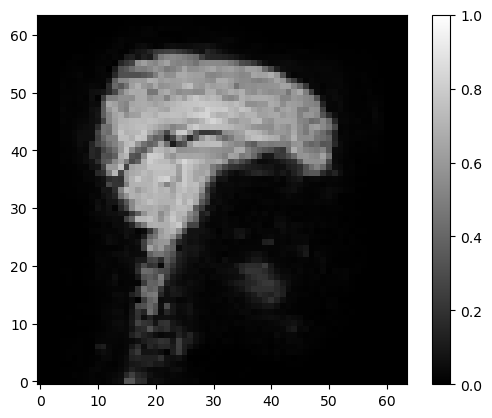

PREDICTED


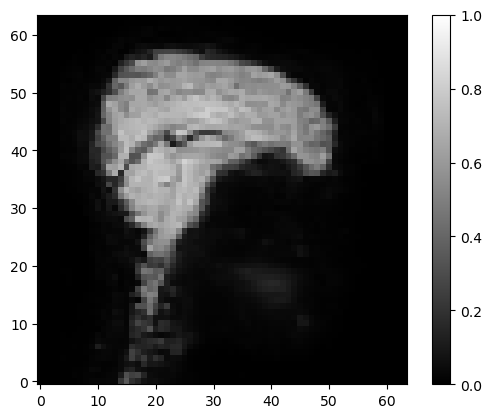

DIFFERENCE


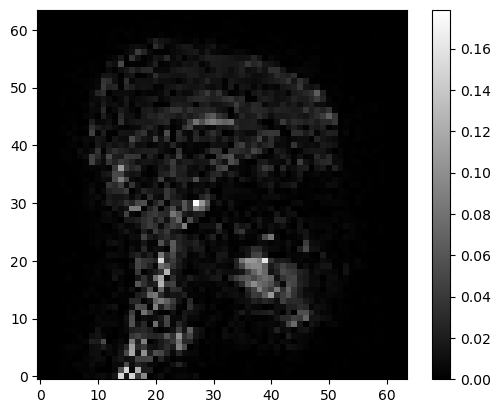

In [27]:
vizualizer.show_scan_slices(100, 0, 20)

TEST


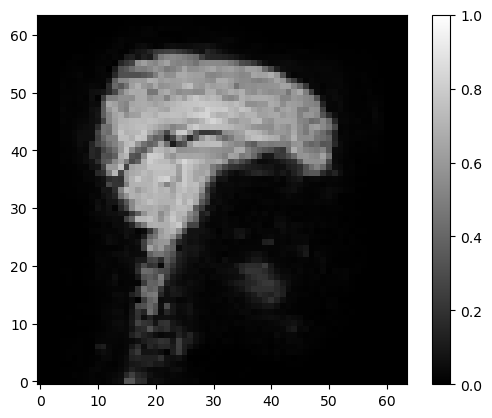

PREDICTED


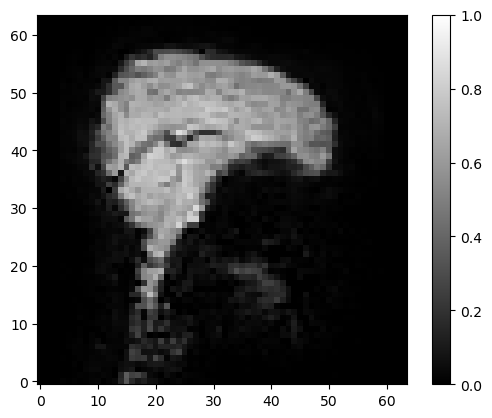

DELTA


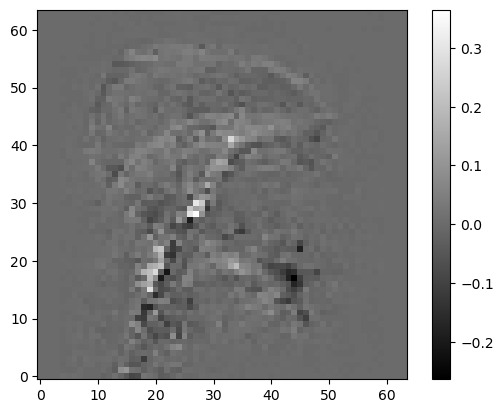

DIFFERENCE


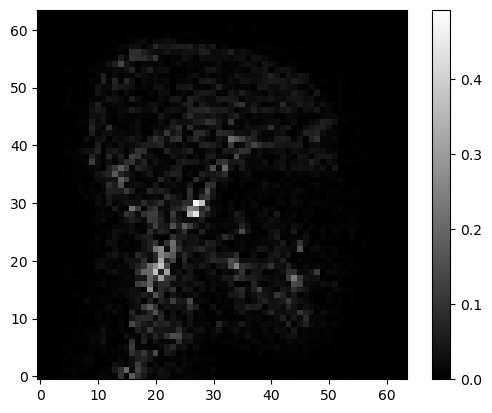

In [28]:
vizualizer_delta.show_recovered_scan_slices(100, 0, 20)

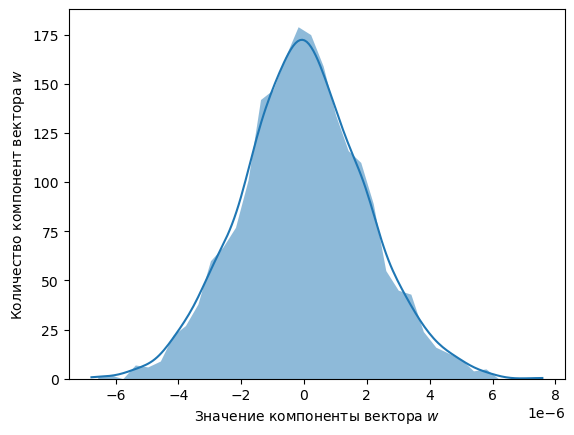

In [29]:
vizualizer_delta.show_voxel_weight_distribution(1000)

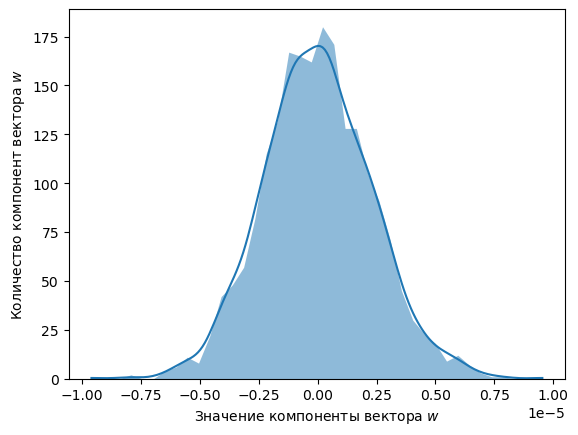

In [30]:
vizualizer_delta.show_mean_weight_distribution()

# Графики зависимостей

In [111]:
t = np.arange(0, 101, 5)
MSE = []
sub = Sub('04')
for dt in t:
    lindeltapred = LinearPredictor(sub, dt, 8, 0)
    lindeltapred.predict()
    MSE.append(lindeltapred.MSE_test)

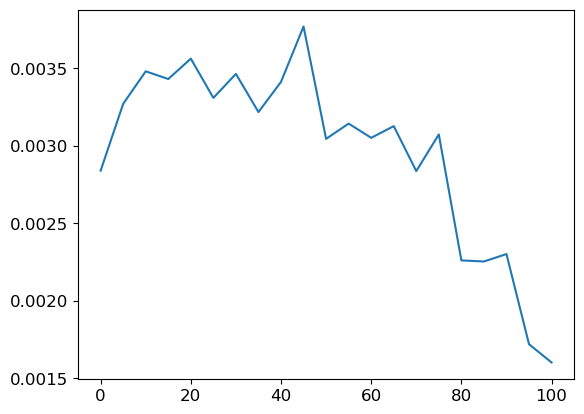

In [112]:
plt.plot(t, MSE)

In [140]:
t = np.arange(0, 101, 5)
MSE_matrix = []

for number in Sub.subs_with_fmri:
    MSE = []
    sub = Sub(number)
    for dt in t:
        lindeltapred = LinearDeltaPredictor(sub, dt, 8, 100)
        lindeltapred.predict()
        MSE.append(lindeltapred.MSE_test)
    MSE_matrix.append(MSE)

MSE_matrix = np.array(MSE_matrix)

In [141]:
path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "MSE_dt.npy")
array = np.array([MSE_matrix], dtype=object)
np.save(path, array, allow_pickle=True)

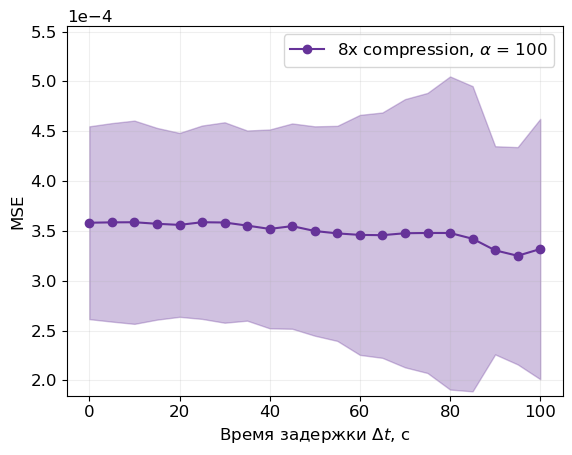

In [142]:
MSE_means = np.array([vector.mean() for vector in MSE_matrix.T])
MSE_stds = np.array([vector.std() for vector in MSE_matrix.T])

plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(t, MSE_means, marker='o', color="rebeccapurple", label=r"8x compression, $\alpha$ = 100")
plt.fill_between(t, MSE_means - MSE_stds, MSE_means + MSE_stds, color="rebeccapurple", alpha = 0.3)
plt.xlabel("Время задержки $\Delta t$, с")
plt.ylabel("MSE")
plt.ylim(0.7 * abs(MSE_means - MSE_stds).max(), 1.1 * abs(MSE_means + MSE_stds).max())
plt.legend()
plt.ticklabel_format(style="sci", axis='y', scilimits=(0, 0))
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_dt_100.pdf"), bbox_inches="tight")

In [130]:
alphas = np.logspace(-3, 8, 12)
MSE_matrix_alpha_8 = []
MSE_matrix_alpha_4 = []
MSE_matrix_alpha_2 = []
MSE_matrix_alpha_1 = []

for number in Sub.subs_with_fmri[:3]:

    MSE_8 = []
    MSE_4 = []
    MSE_2 = []
    MSE_1 = []
    sub = Sub(number)

    for alpha in alphas:

        lindeltapred = LinearDeltaPredictor(sub, 5, 8, alpha)
        lindeltapred.predict()
        MSE_8.append(lindeltapred.MSE_test)

        lindeltapred = LinearDeltaPredictor(sub, 5, 4, alpha)
        lindeltapred.predict()
        MSE_4.append(lindeltapred.MSE_test)

        lindeltapred = LinearDeltaPredictor(sub, 5, 2, alpha)
        lindeltapred.predict()
        MSE_2.append(lindeltapred.MSE_test)

        lindeltapred = LinearDeltaPredictor(sub, 5, 1, alpha)
        lindeltapred.predict()
        MSE_1.append(lindeltapred.MSE_test)

    MSE_matrix_alpha_8.append(MSE_8)
    MSE_matrix_alpha_4.append(MSE_4)
    MSE_matrix_alpha_2.append(MSE_2)
    MSE_matrix_alpha_1.append(MSE_1)

MSE_matrix_alpha_8 = np.array(MSE_matrix_alpha_8)
MSE_matrix_alpha_4 = np.array(MSE_matrix_alpha_4)
MSE_matrix_alpha_2 = np.array(MSE_matrix_alpha_2)
MSE_matrix_alpha_1 = np.array(MSE_matrix_alpha_1)

In [132]:
path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "MSE_alpha.npy")
array = np.array([MSE_matrix_alpha_8, MSE_matrix_alpha_4, MSE_matrix_alpha_2, MSE_matrix_alpha_1], dtype=object)
np.save(path, array, allow_pickle=True)

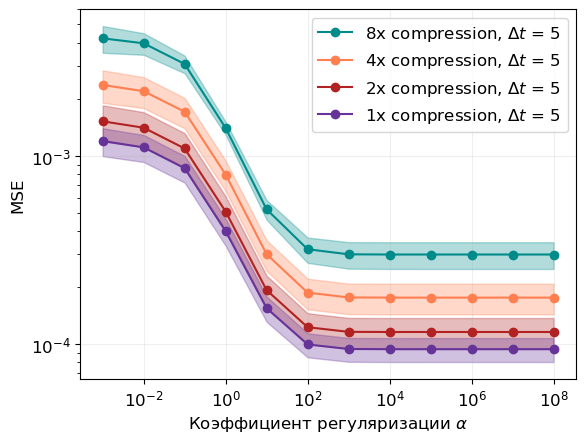

In [137]:
MSE_means_alpha_8 = np.array([vector.mean() for vector in MSE_matrix_alpha_8.T])
MSE_stds_alpha_8 = np.array([vector.std() for vector in MSE_matrix_alpha_8.T])

MSE_means_alpha_4 = np.array([vector.mean() for vector in MSE_matrix_alpha_4.T])
MSE_stds_alpha_4 = np.array([vector.std() for vector in MSE_matrix_alpha_4.T])

MSE_means_alpha_2 = np.array([vector.mean() for vector in MSE_matrix_alpha_2.T])
MSE_stds_alpha_2 = np.array([vector.std() for vector in MSE_matrix_alpha_2.T])

MSE_means_alpha_1 = np.array([vector.mean() for vector in MSE_matrix_alpha_1.T])
MSE_stds_alpha_1 = np.array([vector.std() for vector in MSE_matrix_alpha_1.T])

plt.rcParams.update({'font.size': 12})
plt.rc("font", family='sans-serif')

plt.plot(alphas, MSE_means_alpha_8, marker='o', color="darkcyan", label=r"8x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_8 - MSE_stds_alpha_8, MSE_means_alpha_8 + MSE_stds_alpha_8, color="darkcyan", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_4, marker='o', color="coral", label=r"4x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_4 - MSE_stds_alpha_4, MSE_means_alpha_4 + MSE_stds_alpha_4, color="coral", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_2, marker='o', color="firebrick", label=r"2x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_2 - MSE_stds_alpha_2, MSE_means_alpha_2 + MSE_stds_alpha_2, color="firebrick", alpha = 0.3)
plt.plot(alphas, MSE_means_alpha_1, marker='o', color="rebeccapurple", label=r"1x compression, $\Delta t$ = 5")
plt.fill_between(alphas, MSE_means_alpha_1 - MSE_stds_alpha_1, MSE_means_alpha_1 + MSE_stds_alpha_1, color="rebeccapurple", alpha = 0.3)
plt.xlabel("Коэффициент регуляризации $\\alpha$")
plt.ylabel("MSE")
#plt.ylim(0.7 * abs(mse_means - mse_stds).max(), 1.1 * abs(mse_means + mse_stds).max())
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.2)

plt.savefig(os.path.join(figures, "subs_MSE_dt_alpha.pdf"), bbox_inches="tight")